# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***

## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import numpy as np
import cv2
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


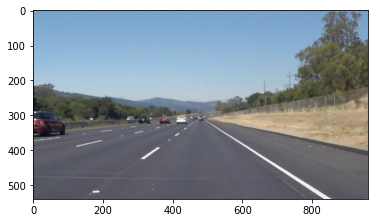

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Helper Functions

In [3]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)

## Test Images

In [4]:
os.listdir("test_images/")

['solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

## Build a Lane Finding Pipeline



In [5]:
# Helper function to generate extrapolated lines
def extrapolated_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    Returns a line image with extrapolated lines
    """
    # Get the lines
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    
    # Separate based on positive and negative slope
    positive_slope = []; negative_slope = []
    for line in lines:
        for x1,y1,x2,y2 in line:
            slope = (y2 - y1) / (x2 - x1)
            if slope > 0:
                positive_slope.append(slope)
            else:
                negative_slope.append(slope)
                
    # Average the values columnwise
    average_positive_slope = np.mean(positive_slope)
    average_negative_slope = np.mean(negative_slope)
    
    # Decide the scope of the line
    # Between which x1, y1 and x2, y2 the line will lie
    # Taken to be the apex point of the ROI and the end of the image
    x1 = 16 * img.shape[1] / 29
    y1 = 7 * img.shape[0] / 11
    if (0 - y1) / average_positive_slope + x1 < 0:
        x2 = img.shape[1]
        y2 = (img.shape[1] - x1) * average_positive_slope + y1
    else:
        x2 = (img.shape[0] - y1) / average_positive_slope + x1
        y2 = img.shape[0]
    average_positive_line = [int(x1), int(y1), int(x2), int(y2)]
    
    x1 = 13 * img.shape[1] / 29
    y1 = 7 * img.shape[0] / 11
    if (img.shape[0] - y1) / average_negative_slope + x1 < 0:
        x2 = 0
        y2 = (0 - x1) * average_negative_slope + y1
    else:
        x2 = (img.shape[0] - y1) / average_negative_slope + x1
        y2 = img.shape[0]
    average_negative_line = [int(x1), int(y1), int(x2), int(y2)]
    
    # Generate the line image 
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    line_image = draw_lines(line_img, [[average_positive_line, average_negative_line]], thickness = 10)
    return line_img

# Helper function to generate subplots
def generate_subplots(name, img_1, title_1, img_2, title_2, img_3, title_3, img_4, title_4):
    """ Function takes in 4 images and shows them in subplots """
    plt.figure(figsize=(25, 15))
    plt.suptitle(name, fontsize=25)
    
    # Subplot 1
    plt.subplot(2, 2, 1)
    plt.title(title_1, fontsize=20)
    plt.imshow(img_1)
    
    # Subplot 2
    plt.subplot(2, 2, 2)
    plt.title(title_2, fontsize=20)
    plt.imshow(img_2)
    
    # Subplot 3
    plt.subplot(2, 2, 3)
    plt.title(title_3, fontsize=20)
    plt.imshow(img_3)
    
    # Subplot 4
    plt.subplot(2, 2, 4)
    plt.title(title_4, fontsize=20)
    plt.imshow(img_4)
    
    # Save the figure
    plt.savefig(f'test_images_output/{name}')

Processing solidWhiteCurve.jpg
Processing solidWhiteRight.jpg
Processing solidYellowCurve.jpg
Processing solidYellowCurve2.jpg
Processing solidYellowLeft.jpg
Processing whiteCarLaneSwitch.jpg


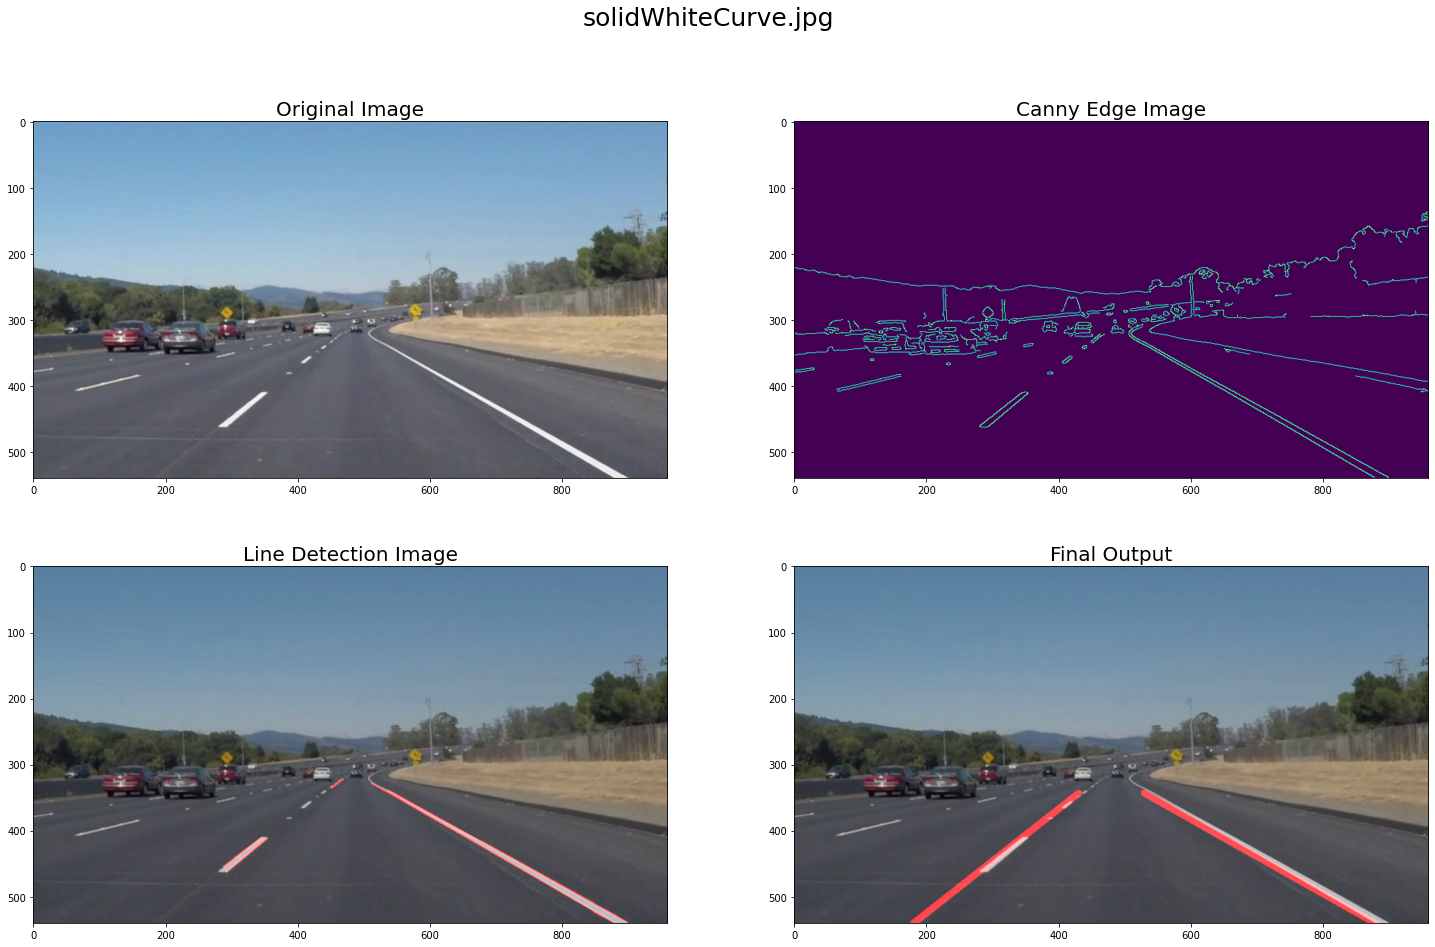

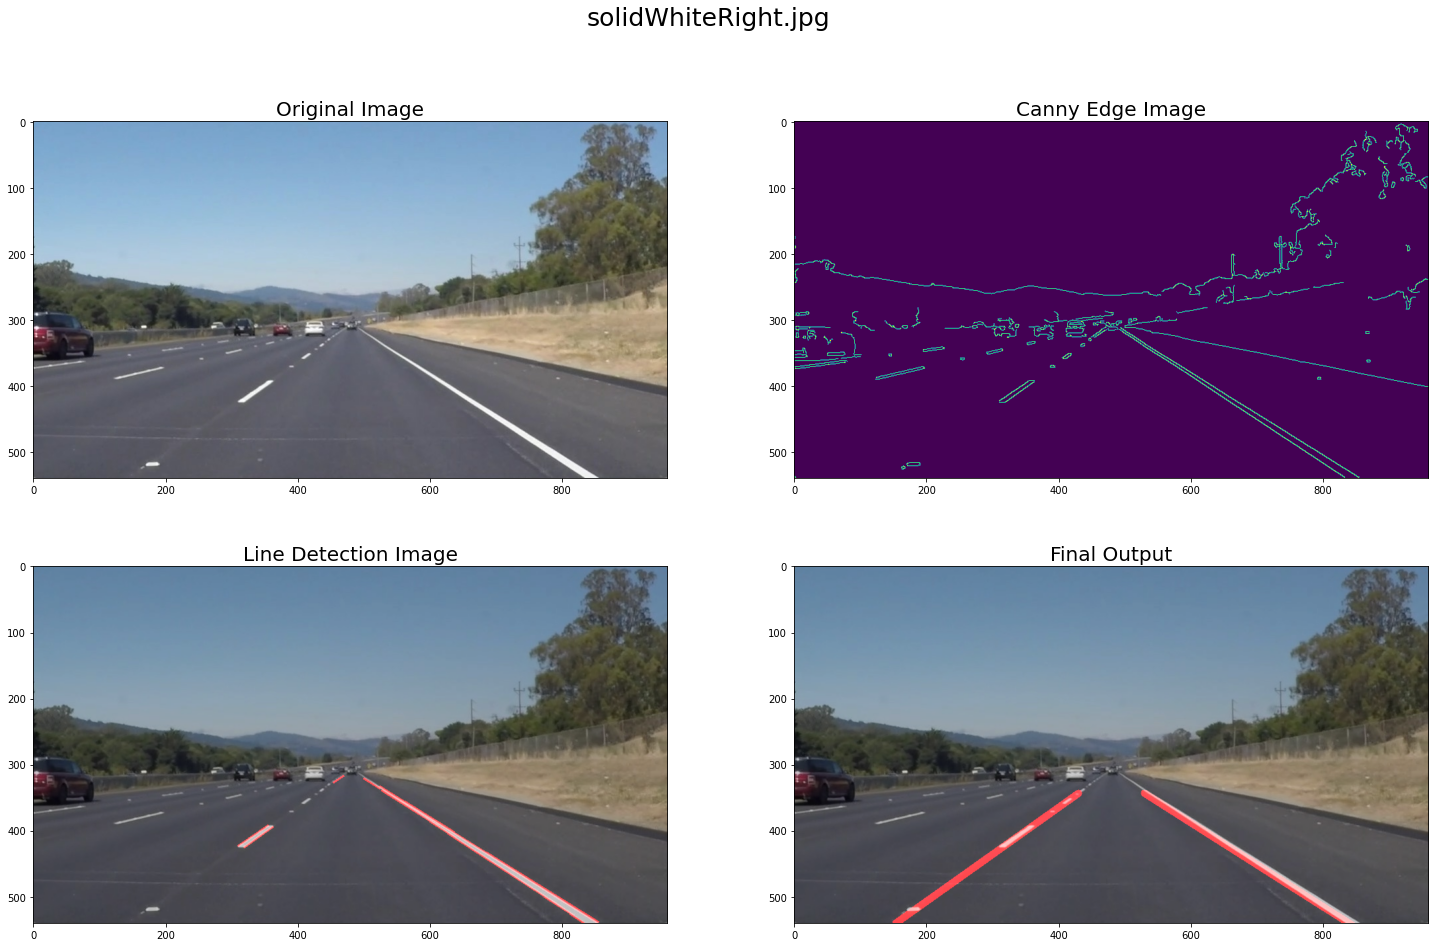

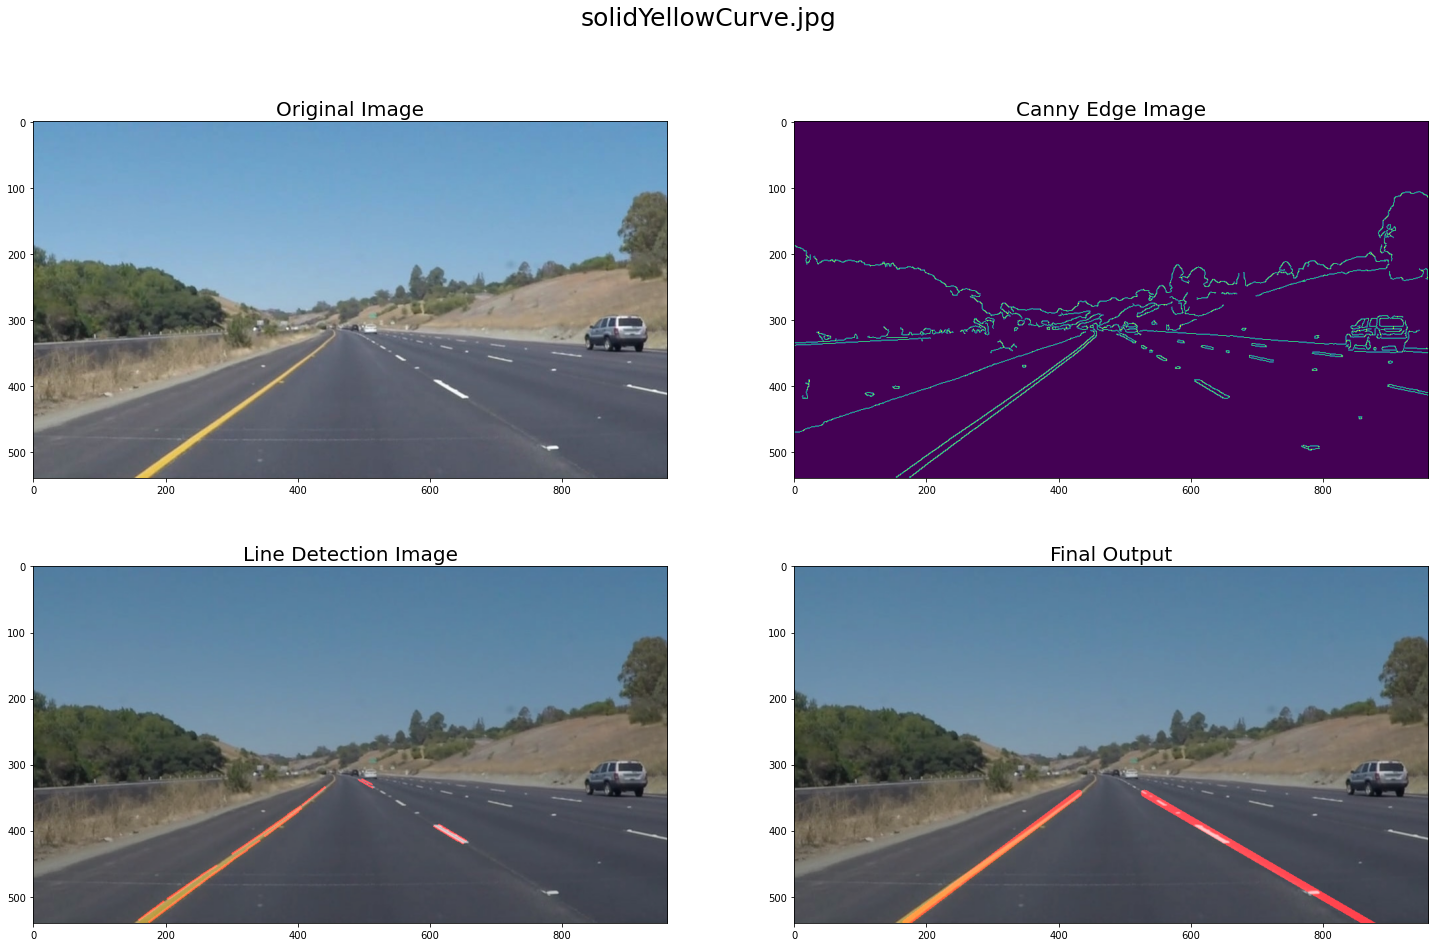

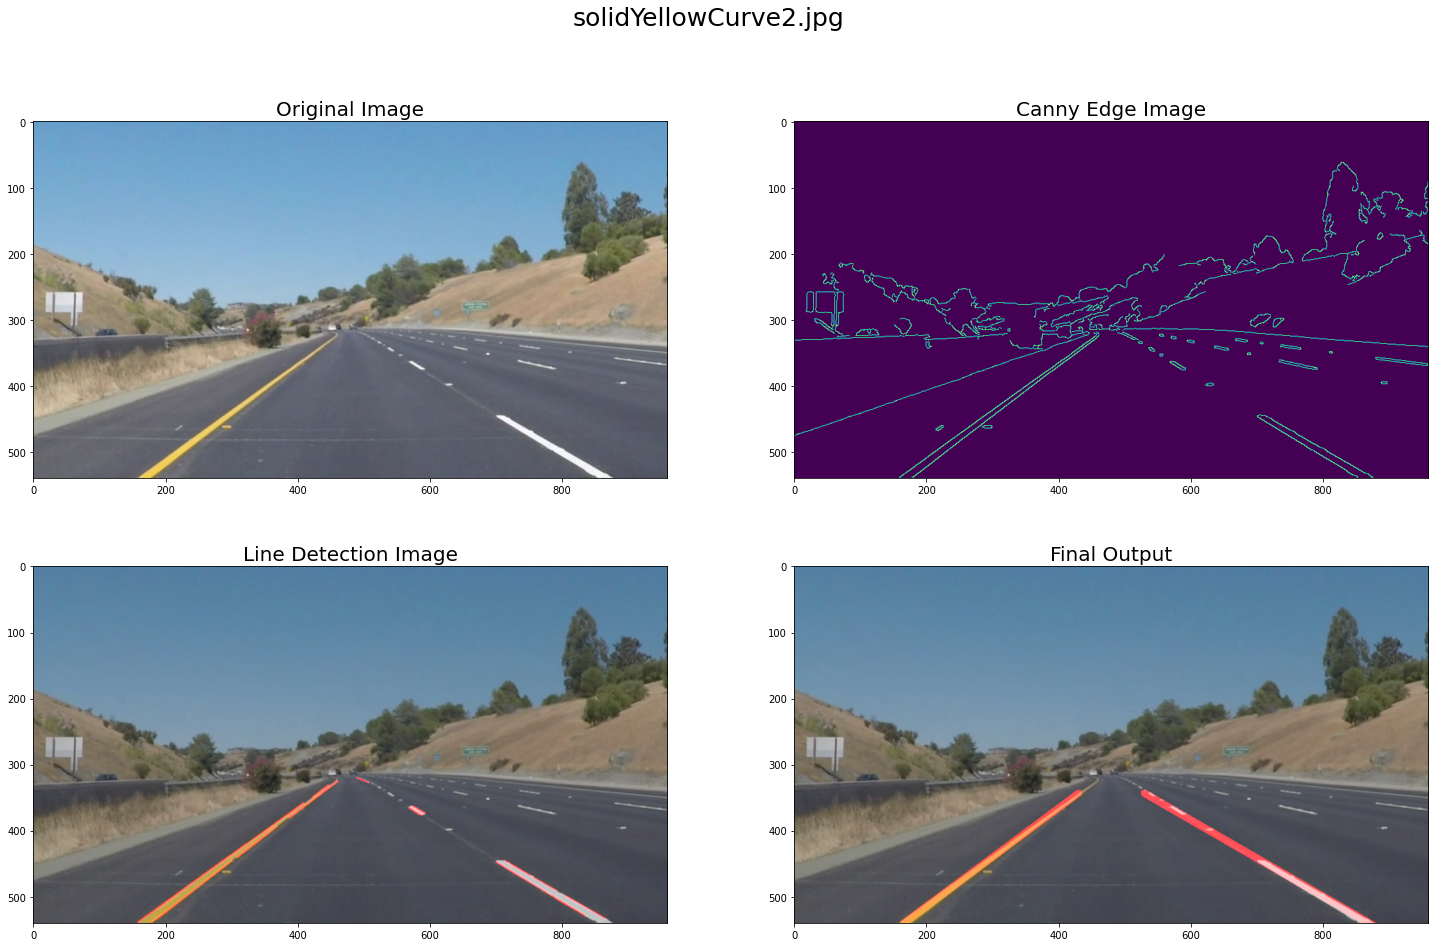

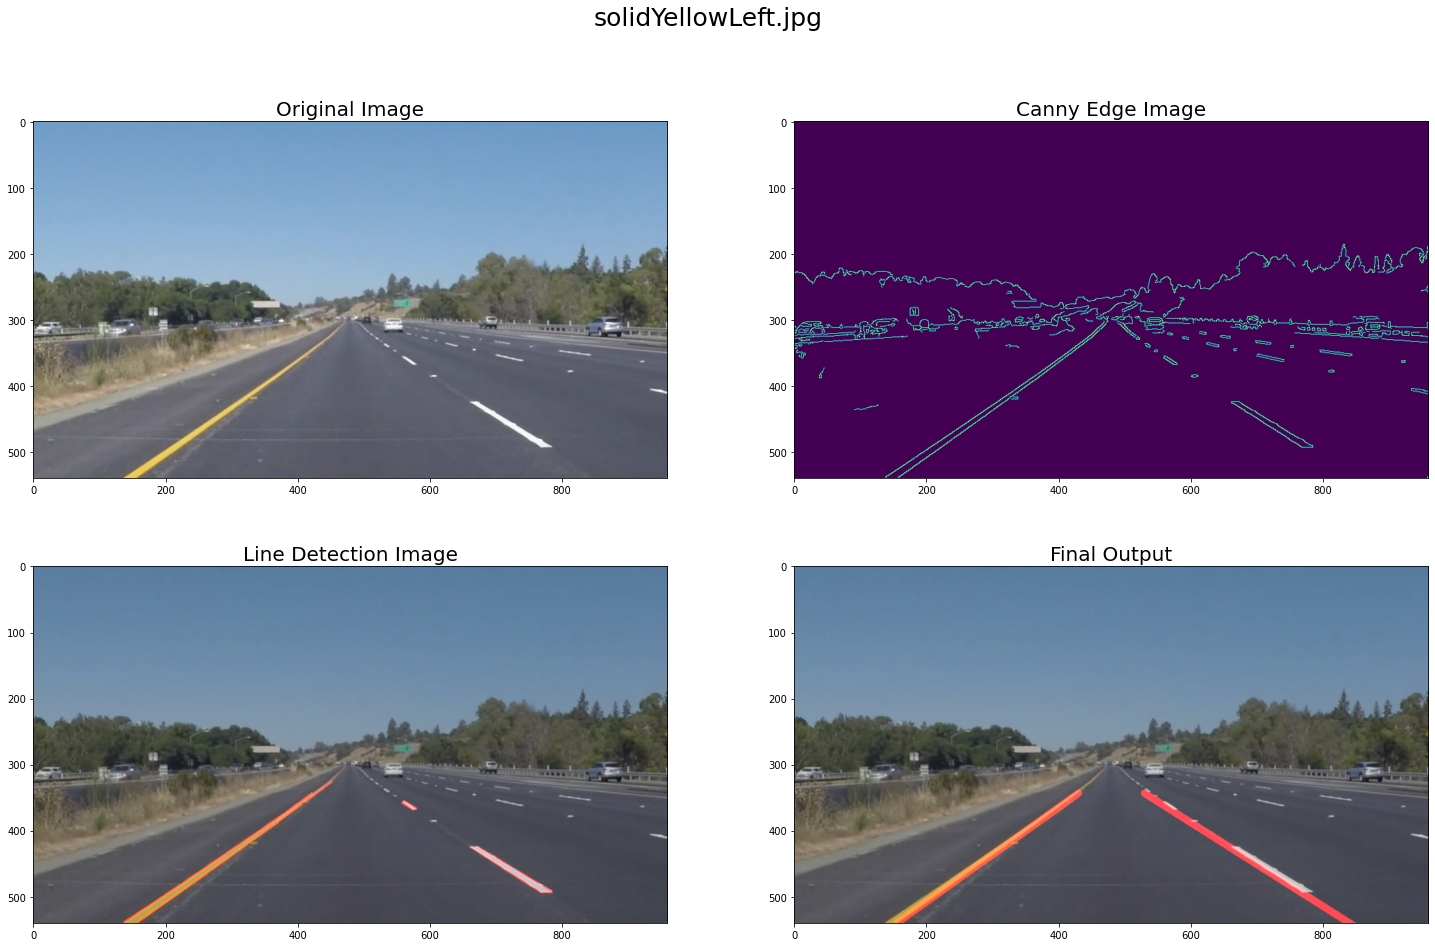

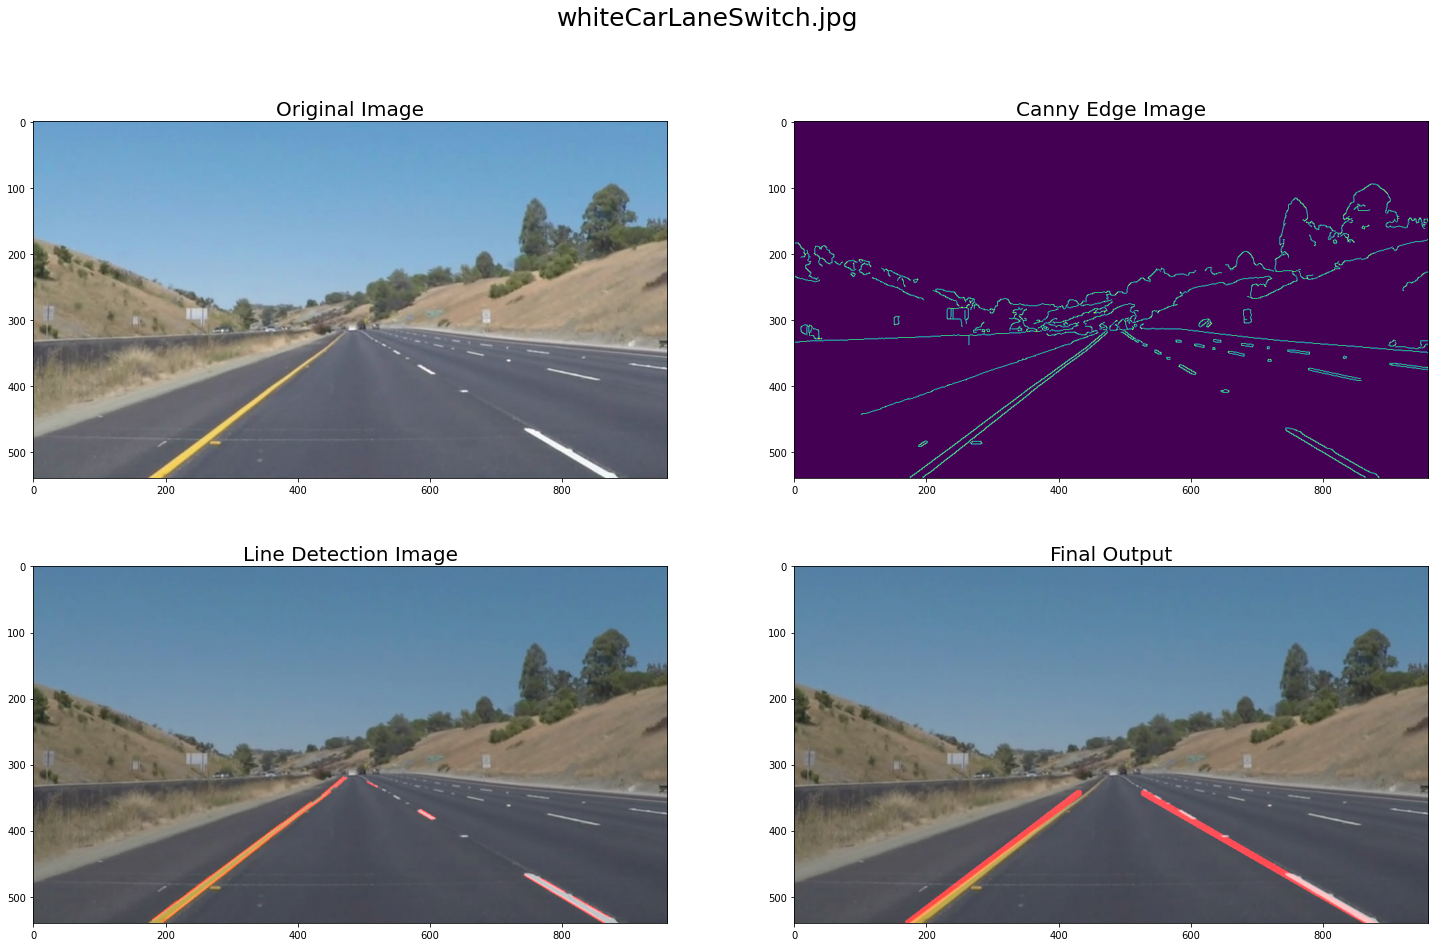

In [6]:
for image_file in os.listdir("test_images/"):
    print(f"Processing {image_file}")
    image = mpimg.imread(f'test_images/{image_file}')
    
    # Convert to gray scale
    gray_image = grayscale(image)

    # Gaussian blur
    blur_image = gaussian_blur(gray_image, 5)

    # Canny Edge Detection
    edge_image = canny(blur_image, 50, 150)

    # Determine the Region of Interest
    point_1 = [0, image.shape[0]]                             # Bottom Left
    point_2 = [image.shape[1], image.shape[0]]                # Bottom Right
    point_3 = [image.shape[1] / 2, 11 * image.shape[0] / 19]   # Middle
    points = np.array([[point_1, point_2, point_3]], dtype = np.int32)
    roi_image = region_of_interest(edge_image, points)

    # Apply Hough Transform
    line_image = hough_lines(roi_image, 1, np.pi / 180, 15, 15, 1)
    semi_final_image = weighted_img(line_image, image)

    # Get extrapolated image
    extrapolated_image = extrapolated_lines(roi_image, 1, np.pi / 180, 30, 15, 1)
    final_image = weighted_img(extrapolated_image, image)
    
    # Generate Subplots
    generate_subplots( 
        image_file,
        image, "Original Image",
        edge_image, "Canny Edge Image",
        semi_final_image, "Line Detection Image",
        final_image, "Final Output"
    )

## Test on Videos

In [7]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [8]:
def process_image(image):
    """ Function to process an individual image """
    # Convert to gray scale
    gray_image = grayscale(image)

    # Gaussian blur
    blur_image = gaussian_blur(gray_image, 5)

    # Canny Edge Detection
    edge_image = canny(blur_image, 50, 150)

    # Determine the Region of Interest
    point_1 = [0, image.shape[0]]                              # Bottom Left
    point_2 = [image.shape[1], image.shape[0]]                 # Bottom Right
    point_3 = [image.shape[1] / 2, 11 * image.shape[0] / 19]   # Middle
    points = np.array([[point_1, point_2, point_3]], dtype = np.int32)
    roi_image = region_of_interest(edge_image, points)

    # Apply Hough Transform
    line_image = hough_lines(roi_image, 1, np.pi / 180, 15, 15, 1)
    final_image = weighted_img(line_image, image)

    # Get extrapolated image
    extrapolated_image = extrapolated_lines(roi_image, 1, np.pi / 180, 30, 15, 1)
    result = weighted_img(extrapolated_image, image)

    return result

### Solid White Right

In [9]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

t:   2%|█▏                                                                   | 4/221 [00:00<00:06, 32.35it/s, now=None]

Moviepy - Building video test_videos_output/solidWhiteRight.mp4.
Moviepy - Writing video test_videos_output/solidWhiteRight.mp4



Moviepy - Done !
Moviepy - video ready test_videos_output/solidWhiteRight.mp4
Wall time: 6.99 s


In [10]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

### Solid Yellow Left

In [11]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

t:   1%|▍                                                                    | 4/681 [00:00<00:21, 31.38it/s, now=None]

Moviepy - Building video test_videos_output/solidYellowLeft.mp4.
Moviepy - Writing video test_videos_output/solidYellowLeft.mp4



Moviepy - Done !
Moviepy - video ready test_videos_output/solidYellowLeft.mp4
Wall time: 24.3 s


In [12]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))